In [6]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torch
import torch.nn as nn

In [7]:
seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [8]:
from utils.dataloader import make_datapath_list, DataTransform

rootpath = './data/VOCdevkit/VOC2012/'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath=rootpath)
# anno 画像を利用するため call

In [9]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

state_dict = torch.load('./weights/pspnet50_30.pth', map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

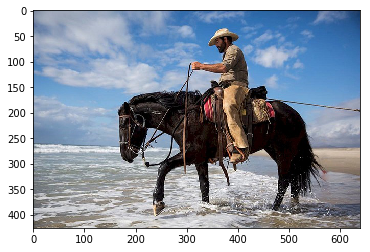

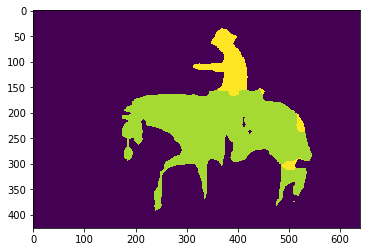

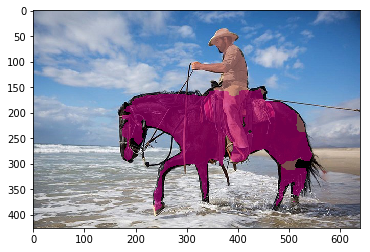

In [11]:
# 元画像の表示
image_file_path = './data/cowboy-757575_640.jpg'
img = Image.open(image_file_path)
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(input_size=475, color_mean=color_mean, color_std=color_std)

# 前処理
# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)
p_palette = anno_class_img.getpalette()
phase = 'val'
img, anno_class_img = transform(phase, img, anno_class_img)

# PSPNetで推論
net.eval()
x = img.unsqueeze(0) # mini batch化 torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0] # AuxLoss側は無視 yのサイズは torch.Size([1, 21, 475, 475])

# PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode='P')
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0,0,0,0))
anno_class_img = anno_class_img.convert('RGBA')

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel
        
        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 150))
            
img = Image.open(image_file_path)
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()